In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-translated-urdu-reviews/imdb_urdu_reviews_test.csv
/kaggle/input/imdb-dataset-of-50k-movie-translated-urdu-reviews/imdb_urdu_reviews_train.csv


## 1. Install  Required Libraries

In [5]:
!pip install urduhack

     |████████████████████████████████| 105 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 15.0 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 3.0.0
    Uninstalling tensorflow-datasets-3.0.0:
      Successfully uninstalled tensorflow-datasets-3.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cloud 0.1.11 requires tensorflow-datasets<3.1.0, but you have tensorflow-datasets 3.2.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Import Libraries

In [6]:
import pandas as pd
import numpy as np

# Import Plotting Libararies
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data Preprocessing Libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models
from sklearn import svm  
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix

### 2.1 Urduhack

Urduhack is a NLP library for urdu language. It comes with a lot of battery included features to help you process Urdu data in the easiest way possible.
 
https://docs.urduhack.com/en/stable/



In [7]:
import urduhack
urduhack.download()
from urduhack.normalization import normalize
from urduhack.preprocessing import normalize_whitespace, remove_punctuation, remove_accents, replace_urls, replace_emails, replace_numbers, replace_currency_symbols, remove_english_alphabets

90112/89078 [==============================] - 0s 0us/step


## 3. Load Dataset
Dataset is available in 2 sets:
* Training
* Testing

In [8]:
train_data = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-translated-urdu-reviews/imdb_urdu_reviews_train.csv")
test_data = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-translated-urdu-reviews/imdb_urdu_reviews_test.csv")

train_data.head(), test_data.head()

(                                              review sentiment
 0  میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...  positive
 1  چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...  negative
 2  ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...  positive
 3  مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...  negative
 4  یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...  positive,
                                               review sentiment
 0  یہ بے گھر خواتین کے بارے میں ایک دستاویزی فلم ...  negative
 1  بالکل بھی اچھ ،ی کام نہیں کیا گیا ، پوری فلم ص...  negative
 2  یہ عجیب بات ہے کہ کچھ لوگوں کا کیا حشر ہوتا ہے...  negative
 3  اور یہ خاص طور پر وکیلوں اور پولیس اہلکاروں کے...  positive
 4  پہلے ، ایک وضاحت: میری سرخی کے باوجود ، میں اس...  positive)

In [9]:
# Combine Both Files to Preprocess 
data =  pd.concat([train_data, test_data]).reset_index(drop=True)
print(data.shape)


(50000, 2)


Make Copy of dataset so we dont have to load again and again

In [10]:
# Make copy of a dataset
df =  data.copy()
df

,review,sentiment
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive
...,...,...
49995,اگر آپ چیخنا چاہتے ہو یا بڑے اسٹوڈیو ہارر پراڈ...,positive
49996,براہ راست یہ ایک محض ایک چھوٹی سی چھوٹی چھوٹی ...,positive
49997,میں نے اس فلم کو کل رات آدھی رات کو چپکے سے پہ...,negative
49998,دیکھنا کوئی آسان فلم نہیں ہے - یہ ساڑھے تین گھ...,positive


We have now 50,000 records available in our dataset. The size of dataset is good and we can build very good predictive model using this data.

Lets see the distribution of label column which is sentiment.

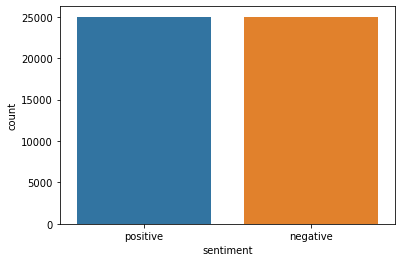

In [11]:
sns.countplot( x = 'sentiment', data = df );

We can see that there are only two classes in our dataset:

* Positive means the review holds positive sentiment.
* Negative means the review holds negative sentiment.

Also the class is very balanced. So, it will be easy for us to build any model.

## 4. Data Preprocessing

### 4.1 Label Encoding of Target Variable

Encode the target label sentiment.

In [13]:
# Encode the labels
le = LabelEncoder()
le.fit(df['sentiment'])
df['encoded_sentiments'] = le.transform(df['sentiment'])
df['encoded_sentiments'].head()

0    1
1    0
2    1
3    0
4    1
Name: encoded_sentiments, dtype: int64

### 4.2 Apply urduhack preprocessing
Now we will apply text cleaning modules from Urdu Hack Library

In [ ]:
df['review'] = df['review'].apply(normalize) # To normalize some text, all you need to do pass unicode text. It will return a str with normalized characters both single and combined, proper spaces after digits and punctuations and diacritics(Zabar - Paish) removed.
# df['review'] = df['review'].apply(remove_punctuation) # Remove punctuation from text by removing all instances of marks. marks=',;:'
df['review'] = df['review'].apply(remove_accents) # Remove accents from any accented unicode characters in text str, either by transforming them into ascii equivalents or removing them entirely.
df['review'] = df['review'].apply(replace_urls) # Replace all URLs in text str with replace_with str.
df['review'] = df['review'].apply(replace_emails) # Replace all emails in text str with replace_with str.
# df['review'] = df['review'].apply(replace_numbers) # Replace all numbers in text str with replace_with str.
df['review'] = df['review'].apply(replace_currency_symbols) # Replace all currency symbols in text str with string specified by replace_with str.
# df['review'] = df['review'].apply(remove_english_alphabets) # Removes English words and digits from a text
df['review'] = df['review'].apply(normalize_whitespace) ## Given text str, replace one or more spacings with a single space, and one or more linebreaks with a single newline. Also strip leading/trailing whitespace.

Using publically available set of Urdu Text Stopwords we will remove stop words from our text.

In [15]:
# Remove stop words from text
from typing import FrozenSet

# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset("""
 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())


def remove_stopwords(text: str):
    return " ".join(word for word in text.split() if word not in STOP_WORDS)

In [16]:
len(STOP_WORDS)

430

In [14]:
df[['review']].head(10)

,review
0,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...
1,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...
2,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...
3,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...
4,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...
5,مجھے اس فلم کا بیشتر حصہ پسند آیا۔ جیسا کہ دوس...
6,ٹھیک ہے ، شاید یہ آسکر کا مستحق نہیں ہے۔ یا گو...
7,میں نے اسے سائنس فائی چینل پر دیکھا۔ یہ پہلے و...
8,یہ فلم ایک ناقص مووی تھی۔ پلاٹ خراب تھا اور کا...
9,یہ ایم جی ایم اور فرینک سناتراس بدترین فلموں م...


In [17]:
from urduhack.models.lemmatizer import lemmatizer
def lemitizeStr(str):
    lemme_str = ""
    temp = lemmatizer.lemma_lookup(str)
    for t in temp:
        lemme_str += t[0] + " "
    
    return lemme_str

In [18]:
df['review'] =  df['review'].apply(remove_stopwords)

In [19]:
df['lemmatized_text'] = df['review'].apply(lemitizeStr)

In [21]:
df['review'][2], df['lemmatized_text'][2]

('معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ، طیارے ملتے ، جگہ جارہا عرصہ ترک کردیا ، بیوی بچ leftہ چھوڑا تھا۔ ذہنی معذور لڑکے قتل الزام ہے۔ دیکھتے ، اخبار عنوان پکڑا عورت پڑھ ہے۔ بے رحمی ، پوچھتی اخبار رکھ ، خاتون دوسرے حصے پیش ہے۔ ٹھیک ، پوچھا ، عورت چاہتی ، حص giveہ پڑھ ہے۔ میتھیو ریان ہوج پریشان فلم لکھا ہدایت معاشرے کئی عکاسی ہے۔ در حقیقت ، ہوج اشارہ غلط ہے۔ فلم لیلینڈ نوعمر عمر پیش ، خیالی حقیقت فرق کرسکتا ہے۔ بات عیاں انسان قتل ، پیارے معصوم لڑکے مستحق ، ، خاندان مقتول لڑکے کنبہ مہلک نتائج برآمد گے۔ حقیقت ، لیلینڈ پتہ جرم ارتکاب چیز ترغیب توبہ ہے۔ ظاہر والدین طلاق لیلینڈ صدمہ پہنچا ہے۔ باپ متلو .ن آدمی پرواہ تھا۔ پرل ، نوعمر حراستی مرکز استاد نوجوان ہنگامہ دیکھتا مدد چاہتا ، بدقسمتی ، موقع ہے۔ فلم اچھی بات ڈان چیڈل ، عمدہ اداکار ہمیشہ بچاتا ہے۔ . ہوج ہدایت کاری تحت جوڑا کاسٹ اچھ workا کام ہے۔ کیون اسپیس ملزم قاتل مغرور والد کردار ادا اچھا موقع تکبر بیوقوف نفرت ہیں۔ تھوڑی ، فلم جوابات زیادہ سوالات ہے۔',
 'معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ، طیارے ملتے ، جگہ جارہا 

In [22]:
df[['review', 'lemmatized_text']].head(10)

,review,lemmatized_text
0,80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...,80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...
1,80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...,80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...
2,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...
3,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...
4,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...
5,فلم بیشتر پسند آیا۔ دوسرے جائزوں بتایا اچھی کا...,فلم بیشتر پسند آیا۔ دوسرے جائزوں بتایا اچھی کا...
6,ٹھیک ، آسکر مستحق ہے۔ گولڈن گلوب۔ ایوارڈ ، معا...,ٹھیک ، آسکر مستحق ہے۔ گولڈن گلوب۔ ایوارڈ ، معا...
7,سائنس فائی چینل دیکھا۔ آیا۔ فلم دلچسپی برقرار ...,سائنس فائی چینل دیکھا۔ آیا۔ فلم دلچسپی برقرار ...
8,"فلم ناقص مووی تھی۔ پلاٹ خراب کامیڈی ""کوشش"" خرا...","فلم ناقص مووی تھی۔ پلاٹ خراب کامیڈی ""کوشش"" خرا..."
9,ایم ایم فرینک سناتراس بدترین فلموں چاہئے۔ اوڈ ...,ایم ایم فرینک سناتراس بدترین فلموں چاہئے۔ اوڈ ...


In [ ]:
df.head()

Now we have cleansed text in lemmatized_text and encoded version of sentiment column as encoded_sentiments.

Data is prepared for the Modeling.

### 4.3 Train Test Split

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(df['lemmatized_text'], df['encoded_sentiments'], test_size = 0.30, random_state = 7, shuffle = True)

In [25]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of Y_train', Y_train.shape)
print('Shape of Y_test', Y_test.shape)

Shape of X_train (35000,)
Shape of X_test (15000,)
Shape of Y_train (35000,)
Shape of Y_test (15000,)


### 4.4 TF - IDF Vectorization

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In [26]:
max_feature_num = 50000
vectorizer = TfidfVectorizer(max_features=max_feature_num)
train_vecs = vectorizer.fit_transform(X_train)
test_vecs = TfidfVectorizer(max_features=max_feature_num, vocabulary=vectorizer.vocabulary_).fit_transform(X_test)

In [27]:
# check the dimensions of feature vectors
train_vecs.shape, test_vecs.shape

((35000, 50000), (15000, 50000))

## 5. Machine Learning Modeling

We will apply multiple machine learning models and compare the accuracies.

### 5.1 Support Vector Machine Classifier

In [28]:
def SVM_classifier(train_vecs, Y_train, test_vecs, Y_test):
    # Training
    SVM = svm.LinearSVC(max_iter=100)
    SVM.fit(train_vecs, Y_train)

    # Testing
    test_predictionSVM = SVM.predict(test_vecs)
    return classification_report(test_predictionSVM, Y_test), confusion_matrix(test_predictionSVM, Y_test)

### 5.2 Logistic Regression Classifier

In [29]:
def LR_classifier(train_vecs, Y_train, test_vecs, Y_test):
    # Training
    LR = LogisticRegression()
    LR.fit(train_vecs, Y_train)

    # testing
    test_predictionLR = LR.predict(test_vecs)
    return classification_report(test_predictionLR, Y_test) , confusion_matrix(test_predictionLR, Y_test)

### 5.3 Decision Tree Classifier

In [30]:
def DT_classifier(train_vecs, Y_train, test_vecs, Y_test):
    # Training
    DT = DecisionTreeClassifier(max_depth = 9, random_state = 23 )
    DT.fit(train_vecs, Y_train)

    # Testing
    test_predictionDT = DT.predict(test_vecs)
    return classification_report(test_predictionDT, Y_test), confusion_matrix(test_predictionDT, Y_test) 

### 5.4 Xgboost Classifier

In [31]:
def XGB_classifier(train_vecs, Y_train, test_vecs, Y_test):
    # Training
    XGB = xgb.XGBClassifier(colsample_bytree = 0.2, learning_rate = 0.01, n_estimators = 100)
    XGB.fit(train_vecs, Y_train)

    # Testing
    test_predictionXGB = XGB.predict(test_vecs)
    return classification_report(test_predictionXGB, Y_test), confusion_matrix(test_predictionXGB, Y_test)  


### 5.5 Random Forest Classifier

In [32]:
def RF_classifier(train_vecs, Y_train, test_vecs, Y_test):
    # Training
    RF = RandomForestClassifier(n_estimators = 450, max_depth=9, random_state=43)
    RF.fit(train_vecs, Y_train)

    # Testing
    test_predictionRF = RF.predict(test_vecs)
    return classification_report(test_predictionRF, Y_test), confusion_matrix(test_predictionRF, Y_test)

## 6. Results - UrduHack and TF-IDF Vectorizer 

In [33]:
class_report , conf_matrix = SVM_classifier(train_vecs, Y_train, test_vecs, Y_test)
print('Results of SVM CLASSIFIER on TF-IDF Vectorizer\n')
print(class_report)
print(conf_matrix)


Results of SVM CLASSIFIER on TF-IDF Vectorizer

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7408
           1       0.87      0.86      0.87      7592

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000

[[6421  987]
 [1049 6543]]


In [34]:
class_report , conf_matrix = LR_classifier(train_vecs, Y_train, test_vecs, Y_test)
print('Results of Logistic Regression Classifier on TF-IDF Vectorizer\n')
print(class_report)
print(conf_matrix)

Results of Logistic Regression Classifier on TF-IDF Vectorizer

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7350
           1       0.88      0.87      0.87      7650

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

[[6444  906]
 [1026 6624]]


In [35]:
class_report , conf_matrix = DT_classifier(train_vecs, Y_train, test_vecs, Y_test)
print('Results of Decision Tree Classifier on TF-IDF Vectorizer\n')
print(class_report)
print(conf_matrix)

Results of Decision Tree Classifier on TF-IDF Vectorizer

              precision    recall  f1-score   support

           0       0.56      0.81      0.66      5220
           1       0.87      0.67      0.75      9780

    accuracy                           0.72     15000
   macro avg       0.72      0.74      0.71     15000
weighted avg       0.76      0.72      0.72     15000

[[4218 1002]
 [3252 6528]]


In [36]:
class_report , conf_matrix = XGB_classifier(train_vecs, Y_train, test_vecs, Y_test)
print('Results of Xgboost Classifier on TF-IDF Vectorizer\n')
print(class_report)
print(conf_matrix)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:15:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results of Xgboost Classifier on TF-IDF Vectorizer

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      6731
           1       0.84      0.76      0.80      8269

    accuracy                           0.79     15000
   macro avg       0.79      0.79      0.79     15000
weighted avg       0.79      0.79      0.79     15000

[[5517 1214]
 [1953 6316]]


In [37]:
class_report , conf_matrix = RF_classifier(train_vecs, Y_train, test_vecs, Y_test)
print('Results of Random Forest Classifier on TF-IDF Vectorizer\n')
print(class_report)
print(conf_matrix)

Results of Random Forest Classifier on TF-IDF Vectorizer

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      7072
           1       0.86      0.81      0.83      7928

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000

[[5989 1083]
 [1481 6447]]


 ## 7. Sentiment Analysis using Word to Vector and Deep Learning 

In [41]:
# Make copy of Dataset to prepare for Word2Vector
df_w2v = df.copy() 

In [42]:
df_w2v.head()

,review,sentiment,encoded_sentiments,lemmatized_text
0,80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...,positive,1,80 دہائی وسط کیبل گائیڈ (اسکائینجر ہنٹ پہلو اپ...
1,80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...,negative,0,80 دہائی انسپکٹر گیجٹ کارٹون پسند ، فلم دیکھنے...
2,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...,positive,1,معاشرے حالت تعجب والد پیدا البرٹ ٹی فٹزجیرالڈ ...
3,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...,negative,0,مفید البرٹ پیون ردی ٹوکری گریڈ زیڈ جلدی۔ ٹم تھ...
4,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...,positive,1,کولمبو ہدایتکاری کیریئر ابتدائی وقت اسٹیون اسپ...


### 7.1 Tokenize the Text using Spacy Urdu Tokenizer

In [44]:
import spacy

In [45]:
def tokenizer(str):
    nlp = spacy.blank('ur')
    doc = nlp.tokenizer(str)
    return [i.text for i in doc]
df_w2v["tokens"] = df_w2v["lemmatized_text"].apply(tokenizer)

We have used spacy tokenizer for urdu text. Urduhack library also provides tokenizer but its bit slow so we used this.

### 7.2 Word to Vector Model
Word2Vec consists of models for generating word embedding. These models are shallow two layer neural networks having one input layer, one hidden layer and one output layer.

In [ ]:
import gensim

model_word2vec = gensim.models.Word2Vec(sentences=df_w2v["tokens"], size=128, window=5, workers=10, min_count = 1)

Lets Check the quality of embeddings generated.

In [ ]:
model_word2vec.wv.most_similar("مرد")

In [ ]:
model_word2vec.wv.most_similar("عورت")

In [ ]:
model_word2vec.wv.most_similar("خوفناک")

In [ ]:
model_word2vec.wv.most_similar("فلم")

In [ ]:
model_word2vec.wv.most_similar("کارٹون")

### 7.3 Embedding Layer Preparation

In [ ]:
VOCAB_SIZE = len(model_word2vec.wv.vocab)
DIMENSIONS = 128
MAX_LEN = max([len(x) for x in df_w2v["tokens"]])

In [ ]:
VOCAB_SIZE, DIMENSIONS, MAX_LEN

* The VOCAB_SIZE shows the size of vocabulary.
* We set the size of dimension to 128 to reduce the dimensions of data.
* The MAX_LEN represents the Maximum length of Sentence in dataset.

In [ ]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(df_w2v["tokens"])
encoded = token.texts_to_sequences(df_w2v["tokens"])

We used Keras Tokenizer to tokenize the data and made text sequences.

In [ ]:
words2vec_matrix = np.zeros((VOCAB_SIZE+1,DIMENSIONS))
for word, index in token.word_index.items():
    try:
        words2vec_matrix[index] = model_word2vec.wv[word]
    except:
        print(index, word)

In [ ]:
import tensorflow as tf
train_vectors = tf.keras.preprocessing.sequence.pad_sequences(encoded,padding='post',dtype=int)

In [ ]:
train_label = df_w2v.encoded_sentiments

In [ ]:
type(train_label[0])

Split the dataset into train and test data.

In [ ]:
(train_sentences,test_sentences, train_tags, test_tags) = train_test_split(train_vectors, train_label, test_size=0.2, shuffle = True)

In [ ]:
train_sentences

### 7.4 1D Convolutional Network
We will build convolutional network to build the model. Conv layer are used to extract the feature from data.

In [ ]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
from tensorflow.keras.optimizers import Adam, Optimizer, SGD
import tensorflow.keras.initializers as Init
from tensorflow.keras import regularizers

In [ ]:
model = Models.Sequential()

model.add(Layers.Embedding(VOCAB_SIZE+1,DIMENSIONS,
                           embeddings_initializer = Init.Constant(words2vec_matrix),
                           input_length=MAX_LEN, trainable=False ))

model.add(Layers.Conv1D(512, 5, activation="relu"))
model.add(Layers.MaxPooling1D(5))

model.add(Layers.Conv1D(256, 5, activation="relu"))
model.add(Layers.MaxPooling1D(5))

model.add(Layers.Conv1D(128, 5, activation="relu"))
model.add(Layers.Dropout(0.3))
model.add(Layers.MaxPooling1D(3))

model.add(Layers.Conv1D(64, 3, activation="relu"))
model.add(Layers.Dropout(0.3))
model.add(Layers.MaxPooling1D(3))

model.add(Layers.Conv1D(32, 3, activation="relu"))
model.add(Layers.Dropout(0.3))

model.add(Layers.Flatten())

model.add(Layers.Dense(32, activation='relu', kernel_regularizer = regularizers.l2(1e-4)))
model.add(Layers.Dropout(0.6))

model.add(Layers.Dense(1,activation='sigmoid'))

model.summary()

model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
CONV_NET = model.fit( train_sentences, train_tags, epochs=10, validation_split=0.20 )

In [ ]:
plt.plot(CONV_NET.history['accuracy'])
plt.plot(CONV_NET.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We can see that the model start overfitting after 5 epochs.

In [ ]:
plt.plot(CONV_NET.history['loss'])
plt.plot(CONV_NET.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The Validation Loss starts increasing after 5 epochs.

In [ ]:
print(classification_report(model.predict(test_sentences).round(), test_tags))

### 7.5 Long Short Term Memory
As LSTM models works good on text data, as they considered the sequences of inputs to make predictions. We will try LSTM Model on this data. 

In [ ]:
lstm = Models.Sequential()

lstm.add(Layers.Embedding(VOCAB_SIZE+1,DIMENSIONS,
                          embeddings_initializer = Init.Constant(words2vec_matrix),
                          input_length=MAX_LEN, trainable=False ))

lstm.add(Layers.Bidirectional(Layers.LSTM(256, activation='tanh')))

lstm.add(Layers.Dense(128, activation='tanh'))
lstm.add(Layers.Dropout(0.3))

lstm.add(Layers.Dense(64, activation='tanh'))
lstm.add(Layers.Dropout(0.3))

lstm.add(Layers.Dense(1, activation='sigmoid'))

lstm.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
 

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es_callback = EarlyStopping(monitor='val_loss', patience=3) 
LSTM_NET = lstm.fit(train_sentences, train_tags, epochs=10, validation_split=0.2, callbacks=[es_callback], shuffle=False)

In [ ]:
plt.plot(LSTM_NET.history['accuracy'])
plt.plot(LSTM_NET.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(LSTM_NET.history['loss'])
plt.plot(LSTM_NET.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The lstm model shows same trend, validation loss starts increasing after 5 epochs.

In [ ]:
print(classification_report(lstm.predict(test_sentences).round(), test_tags))

## 8. Conclusion

We have preprocessed the text data using urduhack library and applied multiple algorithms on this dataset and achieved maximum accuracy of 87 percent using Logistic Regression. In a another notebook we have acieved 88 percent accuracy using SVM but after preprocessing using urduhack the accuracy falls down. So we can conclude that the urduhack text processing preprocess the text quite well but also affects the accuracy.


Then we build the Word to Vector embeddings and build deep learning models. We build 2 models, LSTM and Convolutional Network and compare their results and noticed that the LSTM works good on this data and achieved the accuracy of 83 percent. We also achieved the same accuracy with ConvNet but LSTM is more stable in results.

## 9. Future Work

In coming days, we will also build Glove Embeddings for this data and train Deep Learning Models.